# Predicting Myers-Briggs Personality Types from Twitter Posts

---

<a id='exploratory-data-analysis'></a>
## Exploratory Data Analysis (EDA)

In [1]:
# Import libraries
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import re
import string
import nltk


import plotly.express as px
import hvplot.pandas

from string import punctuation

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.svm import SVC

import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn import (datasets, naive_bayes, feature_extraction, pipeline, linear_model,
metrics, neural_network, model_selection, feature_selection)

from textblob import TextBlob

In [2]:
# Load dataset
df = pd.read_csv('resources/mbti_clean.csv')

<a id='data-dictionary'></a>
**Data Dictionary** 

Variables in original dataframe:
- *type*: (string) four-letter Myers-Briggs Type Index (MBTI) code
- *posts*: (string) text of fifty most recent posts to the *PersonalityCafe* forum

New variables added for analysis in the *df* dataframe:
- *I-E*: (string) code on Introversion-Extroversion axis, derived from *type*
- *N-S*: (string) code on Intuition-Sensing axis, derived from *type*
- *T-F*: (string) code on Thinking-Feeling axis, derived from *type*
- *J-P*: (string) code on Judging-Perceiving axis, derived from *type*
- *posts_r*: (string) cleaned post text, derived from *posts*
- *total_words*: (integer) number of total words across 50 posts, derived from *posts*
- *avg_words_per_post*: (float) average number of words per post, derived from *posts* and *total words*
- *polarity*: (float) polarity score (range -1 to 1)
- *subjectivity*: (float) subjectivity score (range 0 to 1)

In [3]:
# View first five rows of dataset
df.head()

,type,posts
0,INFJ,The last thing INFJ friend posted his facebo...
1,INFJ,Hello ENFJ Sorry hear your distress Its only...
2,INFJ,Prozac wellbrutin least thirty minutes movin...
3,INFJ,Basically come with three items youve determi...
4,INFJ,All things moderation Sims indeed video ga...


In [4]:
# View shape of dataset
df.shape

(283792, 2)

In [5]:
# View information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283792 entries, 0 to 283791
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   type    283792 non-null  object
 1   posts   283792 non-null  object
dtypes: object(2)
memory usage: 4.3+ MB


The column names are 'type' and 'posts'. Both are datatype 'object'. There are no null values.

In [6]:
# Examine number of unique items are in the 'type' (classification) column
df['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

The 'type' column contains 16 unique codes, representing the 16 different personality types.

In [7]:
# Explore the counts for each of these types
df['type'].value_counts()

INFP    60583
INFJ    50417
INTP    42071
INTJ    35109
ENFP    22361
ENTP    21922
ISTP    10404
ISFP     8089
ENTJ     7597
ISTJ     6679
ENFJ     6481
ISFJ     5435
ESTP     2697
ESFJ     1441
ESFP     1256
ESTJ     1250
Name: type, dtype: int64

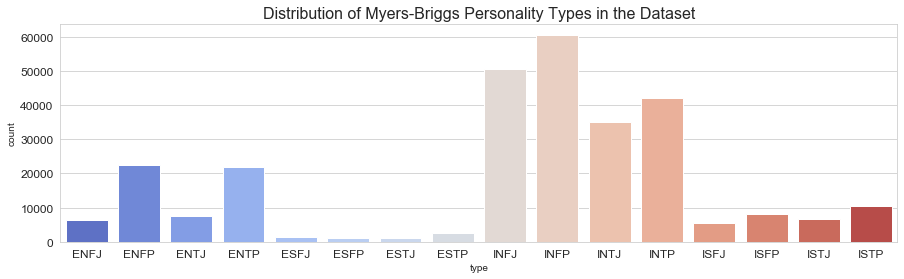

In [8]:
# Countplot of the 16 personality types in the dataset
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.countplot(x="type", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Distribution of Myers-Briggs Personality Types in the Dataset", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [9]:
# Explore the counts for each axis of the types
print('Introversion (I) – Extroversion (E)', '\n', df['type'].map(lambda x: x[0]).value_counts(), '\n')
print('Intuition (N) – Sensing (S)', '\n', df['type'].map(lambda x: x[1]).value_counts(), '\n')
print('Thinking (T) – Feeling (F)', '\n', df['type'].map(lambda x: x[2]).value_counts(), '\n')
print('Judging (J) – Perceiving (P)', '\n', df['type'].map(lambda x: x[3]).value_counts(), '\n')

Introversion (I) – Extroversion (E) 
 I    218787
E     65005
Name: type, dtype: int64 

Intuition (N) – Sensing (S) 
 N    246541
S     37251
Name: type, dtype: int64 

Thinking (T) – Feeling (F) 
 F    156063
T    127729
Name: type, dtype: int64 

Judging (J) – Perceiving (P) 
 P    169383
J    114409
Name: type, dtype: int64 



The dataset contains many more Introverts (I) than Extroverts (E), and more Intuitives (N) than Sensers (S). The distributions of Thinkers (T) vs. Feelers (F), and Judgers (J) vs. Perceivers (P) are more balanced.

---

<a id='preprocessing'></a>
## Preprocessing

In [10]:
# Create a working copy of the dataframe
df_working = df.copy()
df_working.head()

,type,posts
0,INFJ,The last thing INFJ friend posted his facebo...
1,INFJ,Hello ENFJ Sorry hear your distress Its only...
2,INFJ,Prozac wellbrutin least thirty minutes movin...
3,INFJ,Basically come with three items youve determi...
4,INFJ,All things moderation Sims indeed video ga...


In [11]:
# Create a binary column for each of the 4 axis types for later analysis
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,The last thing INFJ friend posted his facebo...,Introversion,Intuition,Feeling,Judging
1,INFJ,Hello ENFJ Sorry hear your distress Its only...,Introversion,Intuition,Feeling,Judging
2,INFJ,Prozac wellbrutin least thirty minutes movin...,Introversion,Intuition,Feeling,Judging
3,INFJ,Basically come with three items youve determi...,Introversion,Intuition,Feeling,Judging
4,INFJ,All things moderation Sims indeed video ga...,Introversion,Intuition,Feeling,Judging


Codes for the new columns:
- I-E: Introversion - Extroversion
- N-S: Intuition - Sensing
- T-F: Thinking - Feeling
- J-P: Judging - Perceiving

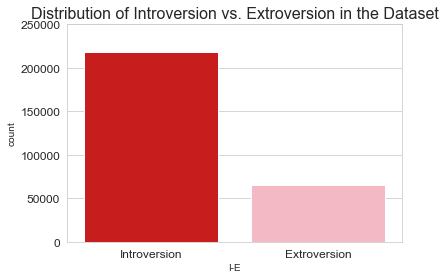

In [12]:
# Plot of Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.countplot(x="I-E", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Distribution of Introversion vs. Extroversion in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above show that the dataset is heavily skewed toward Introversion over Extroversion.

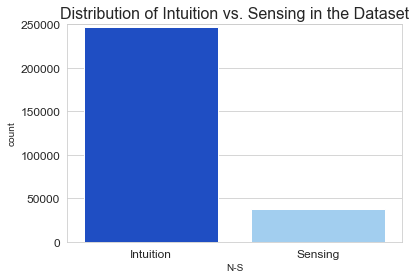

In [13]:
# Plot of Intuition - Sensing axis
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.countplot(x="N-S", data=df_working, order=["Intuition", "Sensing"])
plt.title("Distribution of Intuition vs. Sensing in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is heavily skewed toward Intuition over Sensing.

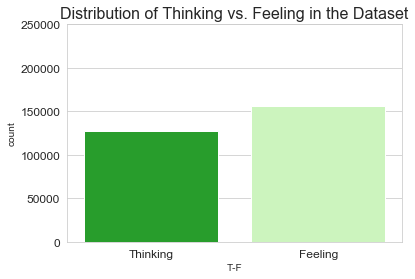

In [14]:
# Plot of Thinking - Feeling axis
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.countplot(x="T-F", data=df_working, order=["Thinking", "Feeling"])
plt.title("Distribution of Thinking vs. Feeling in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is somewhat skewed toward Feeling over Thinking.

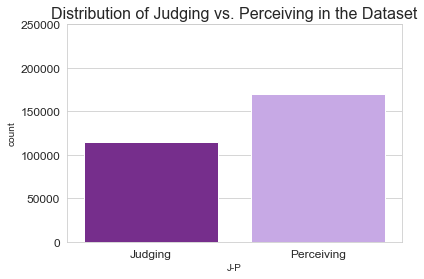

In [15]:
# Plot of Judging - Perceiving axis
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.countplot(x="J-P", data=df_working, order=["Judging", "Perceiving"])
plt.title("Distribution of Judging vs. Perceiving in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is moderately skewed toward Perceiving over Judging.

In [16]:
# Subset the posts column for further exploration
posts = df['posts'].str.lower()

#### Word count

In [17]:
# Create the stopwords list
stoplist = stopwords.words('english') + list(punctuation)

# Add to the stopwords list each of the 16 codes
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', \
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj', 'facebook']

for type in types:
    stoplist.append(type)
    

# Create empty list where individual words will be saved
words = [] 

# Split the words from each posts (tweet)
for w in posts:
    tweet = w.split()
    # Remove stop words from tweet 
    for word in tweet:
        if not word in stoplist: 
            words.append(word)

# Create a collection (word counter)
word_count = Counter(word_tokenize('\n'.join(words)))

# Create empty lists word_top_25 and freq_top_25
words_top_25 = []
freq_top_25 = []

print("\nMost frequent words with counts:")

# Find and print the most common words (top 25)
for word, frequency in word_count.most_common(25):
    print('%s: %d' % (word, frequency))
    words_top_25.append(word)
    freq_top_25.append(frequency)
print("\n")


Most frequent words with counts:
like: 60784
dont: 47647
think: 44665
people: 43085
know: 32985
really: 31821
one: 31603
would: 30973
get: 27596
ive: 27445
time: 24347
feel: 21142
much: 20473
well: 19531
things: 19089
say: 17957
something: 17696
way: 17685
good: 17443
want: 17245
see: 16926
love: 16820
also: 16617
even: 15406
always: 15177




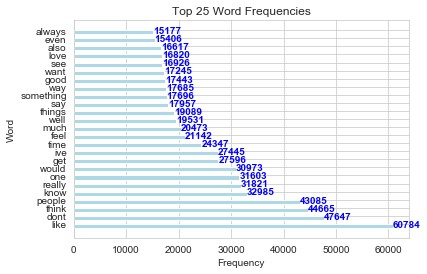

In [18]:
# Plot the counts of the 25 most frequent words
# Horizontal Boxplots
fig, ax = plt.subplots()
width = 0.5
ind = np.arange(len(words_top_25))
ax.barh(ind, freq_top_25, width, color = 'lightblue')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(words_top_25, minor = False)
for i, v in enumerate(freq_top_25):
    ax.text(v + 2, i - 0.125, str(v), color = 'blue', fontweight = 'bold')
plt.title('Top 25 Word Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

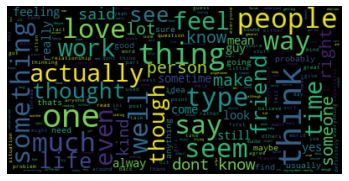

In [19]:
# Wordcloud Why not??
from wordcloud import WordCloud
from os import path

wordcloud_words = " ".join(words)
# Lower max font size
wordcloud = WordCloud(max_font_size = 40).generate(wordcloud_words)
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

---

<a id='classification'></a>
## Classification

<a id='multiclass-classification'></a>
### Multiclass classification (16 classes)

##### Baseline calculation

A baseline is a fixed point of reference that is used for comparison purposes.

Predicting "INFP" *(most frequent type)* every time.

The accuracy will be the number of entries of "INFP" divided by the total number of entries of all personality types.

In [20]:
# Determine baseline
print("The count for the most frequent type (INFP) is: ", df['type'].value_counts().max())


print("The total count of personality type entries is: ", df['type'].value_counts().sum())


baseline = df['type'].value_counts().max() / df['type'].value_counts().sum()
print(f"The baseline is: {df['type'].value_counts().max() / df['type'].value_counts().sum(): .3f}")

The count for the most frequent type (INFP) is:  60583
The total count of personality type entries is:  283792
The baseline is:  0.213


##### Train-test split

In [21]:
# Train-test split, using type variable as target and posts variable as predictor
X_train, X_test, y_train, y_test = train_test_split(df['posts'].values,
                                                   df[['type']].values,
                                                   test_size=0.30, random_state=42)

print("X_train: ", len(X_train))
print("-----------------")
print("X_test: ", len(X_test)) 
print("-----------------")
print("y_train: ", len(y_train))
print("-----------------")
print("y_test: ", len(y_test))
print("-----------------")



X_train:  198654
-----------------
X_test:  85138
-----------------
y_train:  198654
-----------------
y_test:  85138
-----------------


##### Truncated SVD

*TruncatedSVD* is a variant of principal component analysis (pca) used on sparse matrices to reduce dimensionality

In [22]:
# Run CountVectorizer on the X train/test ('posts' column)
cv = CountVectorizer(stop_words=stoplist, ngram_range=(1,2), max_features=1000)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)

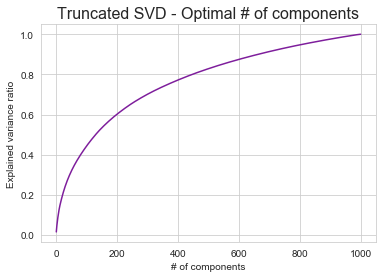

In [23]:
# Run Truncated SVD
# First use max components and graph the explained variance ratio to find cutoff point 
tsvd = TruncatedSVD(n_components=999)
tsvd.fit(X_train_cv)
plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title("Truncated SVD - Optimal # of components", fontsize=16)
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio");

The graph above suggests that approximately 200 components would be most effective, since it is where the explained variance begins to flatten out.

In [24]:
# Run a Truncated SVD with 200 components
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(X_train_cv)
X_train_tsvd = tsvd.transform(X_train_cv)

X_test_cv = cv.transform(X_test)
X_test_tsvd = tsvd.transform(X_test_cv)

**Preprocessing Pipeline**

In [25]:
# Pipeline for the data preprocessing steps (CountVectorizer, TruncatedSVD) on the X data
pipeline_preprocessing = make_pipeline(
    CountVectorizer(stop_words=stoplist, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=200))

X_train_tsvd = pipeline_preprocessing.fit_transform(X_train)
X_test_tsvd = pipeline_preprocessing.transform(X_test)

<a id='modeling'></a>
### Modeling

<a id='random-forest-classifier'></a>
#### Model: Random Forest Classifier

*RandomForestClassifier* is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [26]:
# Create a random forest classifier.
rfc = RandomForestClassifier(n_estimators=30, random_state=123)

# Fitting the model
rfc = rfc.fit(X_train_tsvd, y_train)

# Evaluate the model
y_pred = rfc.predict(X_test_tsvd)
print(f"Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")
print("____________________________________________________")
print("Classification Report:")
print(classification_report(y_test, y_pred))

C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Random forest predictive accuracy: 0.199
____________________________________________________
Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.20      0.01      0.01      1968
        ENFP       0.11      0.04      0.06      6749
        ENTJ       0.29      0.01      0.02      2223
        ENTP       0.09      0.03      0.05      6577
        ESFJ       0.80      0.01      0.02       448
        ESFP       0.60      0.01      0.02       374
        ESTJ       0.25      0.00      0.00       410
        ESTP       0.57      0.01      0.03       801
        INFJ       0.19      0.33      0.24     15074
        INFP       0.23      0.46      0.31     18285
        INTJ       0.16      0.10      0.12     10587
        INTP       0.17      0.14      0.15     12631
        ISFJ       0.10      0.00      0.00      1593
        ISFP       0.51      0.01      0.02      2428
        ISTJ       0.38      0.01      0.01      1945
        ISTP      

In [27]:
# Convert confusion matrix to a dataframe to prepare it for heatmapping
cm_rfc = np.array(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))

cm_randomforest = pd.DataFrame(cm_rfc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])

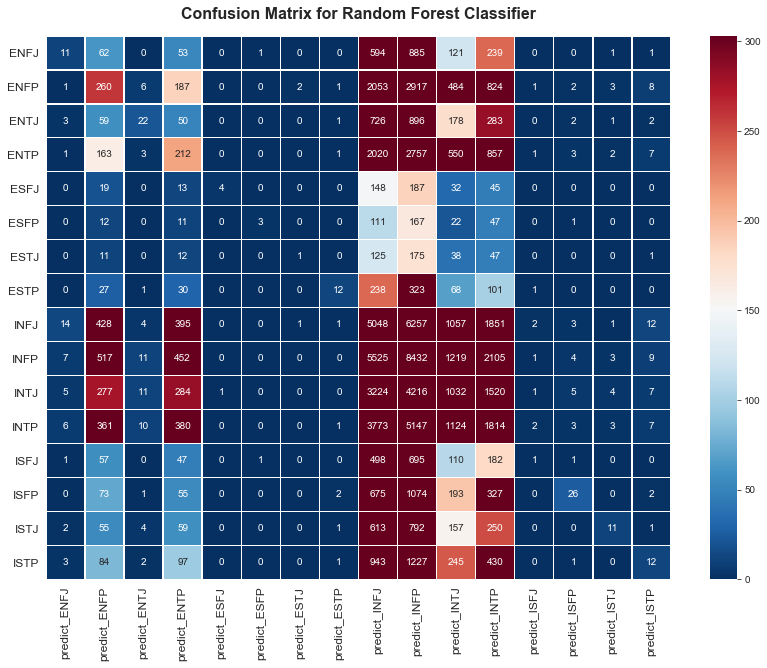

In [28]:
# Create confusion matrix heatmap of Random Forest Classifier model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=16,
          fontweight='bold', y=1.02)
sns.heatmap(cm_randomforest, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

In the heatmapped confusion matrix above, it is clear that the Random Forest Classifier model is making predictions mostly within six of the sixteen classes:
INFJ, INFP, INTJ, INTP, ENFP, and ENTP.
The other ten categories receive very low predictions or no predictions from this model at all. This model accuracy has a slightly lower accuracy than the baseline and it is not suited to predicting classes outside of the ones with the highest frequency.

<a id='neural-network-classifier'></a>
#### Model: Neural Network

In [30]:
# Scale the training and testing input features using StandardScaler
X_scaler = StandardScaler()
X_scaler.fit(X_train_tsvd)

X_train_scaled = X_scaler.transform(X_train_tsvd)
X_test_scaled = X_scaler.transform(X_test_tsvd)

In [31]:
# Apply One-hot encoding to the target labels
#y_test = np.asarray(y_test).reshape((-1,1))
#y_train = np.asarray(y_train).reshape((-1,1))
enc = OneHotEncoder() 
enc.fit(y_train)

encoded_y_train = enc.transform(y_train).toarray()
encoded_y_test = enc.transform(y_test).toarray()
encoded_y_train[0]
encoded_y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [32]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train_scaled.shape[1]
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))



# Output layer
nn.add(tf.keras.layers.Dense(units=16, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Define the checkpoint path and filenames
os.makedirs("Optimization_Checkpoints/checkpoints3/",exist_ok=True)
checkpoint_path = "Optimization_Checkpoints/checkpoints3/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights 
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4020)

# Train the model
fit_model = nn.fit(X_train_scaled, encoded_y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
3990/6208 [==================>...........] - ETA: 3s - loss: 0.2277 - accuracy: 0.1906
Epoch 00001: saving model to Optimization_Checkpoints/checkpoints3\weights.01.hdf5
6208/6208 [==============================] - 9s 1ms/step - loss: 0.2196 - accuracy: 0.1977
Epoch 2/100
1800/6208 [=======>......................] - ETA: 4s - loss: 0.1977 - accuracy: 0.2288
Epoch 00002: saving model to Optimization_Checkpoints/checkpoints3\weights.02.hdf5
5836/6208 [===========================>..] - ETA: 0s - loss: 0.1981 - accuracy: 0.2253
Epoch 00002: saving model to Optimization_Checkpoints/checkpoints3\weights.02.hdf5
6208/6208 [==============================] - 7s 1ms/step - loss: 0.1981 - accuracy: 0.2252
Epoch 3/100
3657/6208 [================>.............] - ETA: 2s - loss: 0.1971 - accuracy: 0.2276
Epoch 00003: saving model to Optimization_Checkpoints/checkpoints3\weights.03.hdf5
6208/6208 [==============================] - 7s 1ms/step - loss: 0.1972 - accuracy: 0.2273
Epoch 4/100

4103/6208 [==================>...........] - ETA: 1s - loss: 0.1921 - accuracy: 0.2600
Epoch 00023: saving model to Optimization_Checkpoints/checkpoints3\weights.23.hdf5
6208/6208 [==============================] - 6s 931us/step - loss: 0.1923 - accuracy: 0.2591
Epoch 24/100
1921/6208 [========>.....................] - ETA: 3s - loss: 0.1922 - accuracy: 0.2599
Epoch 00024: saving model to Optimization_Checkpoints/checkpoints3\weights.24.hdf5
5910/6208 [===========================>..] - ETA: 0s - loss: 0.1924 - accuracy: 0.2586
Epoch 00024: saving model to Optimization_Checkpoints/checkpoints3\weights.24.hdf5
6208/6208 [==============================] - 6s 934us/step - loss: 0.1924 - accuracy: 0.2585
Epoch 25/100
3751/6208 [=================>............] - ETA: 2s - loss: 0.1919 - accuracy: 0.2623
Epoch 00025: saving model to Optimization_Checkpoints/checkpoints3\weights.25.hdf5
6208/6208 [==============================] - 6s 926us/step - loss: 0.1922 - accuracy: 0.2609
Epoch 26/100
15

4191/6208 [===================>..........] - ETA: 1s - loss: 0.1912 - accuracy: 0.2665
Epoch 00045: saving model to Optimization_Checkpoints/checkpoints3\weights.45.hdf5
6208/6208 [==============================] - 6s 944us/step - loss: 0.1913 - accuracy: 0.2653
Epoch 46/100
2040/6208 [========>.....................] - ETA: 3s - loss: 0.1902 - accuracy: 0.2705
Epoch 00046: saving model to Optimization_Checkpoints/checkpoints3\weights.46.hdf5
6051/6208 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.2671
Epoch 00046: saving model to Optimization_Checkpoints/checkpoints3\weights.46.hdf5
6208/6208 [==============================] - 6s 938us/step - loss: 0.1910 - accuracy: 0.2670
Epoch 47/100
3856/6208 [=================>............] - ETA: 2s - loss: 0.1915 - accuracy: 0.2644
Epoch 00047: saving model to Optimization_Checkpoints/checkpoints3\weights.47.hdf5
6208/6208 [==============================] - 6s 960us/step - loss: 0.1916 - accuracy: 0.2637
Epoch 48/100
16

4313/6208 [===================>..........] - ETA: 1s - loss: 0.1910 - accuracy: 0.2659
Epoch 00067: saving model to Optimization_Checkpoints/checkpoints3\weights.67.hdf5
6208/6208 [==============================] - 6s 953us/step - loss: 0.1911 - accuracy: 0.2658
Epoch 68/100
2093/6208 [=========>....................] - ETA: 3s - loss: 0.1909 - accuracy: 0.2671
Epoch 00068: saving model to Optimization_Checkpoints/checkpoints3\weights.68.hdf5
6153/6208 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.2659
Epoch 00068: saving model to Optimization_Checkpoints/checkpoints3\weights.68.hdf5
6208/6208 [==============================] - 6s 933us/step - loss: 0.1911 - accuracy: 0.2659
Epoch 69/100
3942/6208 [==================>...........] - ETA: 2s - loss: 0.1906 - accuracy: 0.2685
Epoch 00069: saving model to Optimization_Checkpoints/checkpoints3\weights.69.hdf5
6208/6208 [==============================] - 6s 941us/step - loss: 0.1908 - accuracy: 0.2673
Epoch 70/100
17

4403/6208 [====================>.........] - ETA: 1s - loss: 0.1904 - accuracy: 0.2691
Epoch 00089: saving model to Optimization_Checkpoints/checkpoints3\weights.89.hdf5
6208/6208 [==============================] - 6s 947us/step - loss: 0.1905 - accuracy: 0.2682
Epoch 90/100
2197/6208 [=========>....................] - ETA: 3s - loss: 0.1906 - accuracy: 0.2641
Epoch 00090: saving model to Optimization_Checkpoints/checkpoints3\weights.90.hdf5
6208/6208 [==============================] - 6s 932us/step - loss: 0.1907 - accuracy: 0.2655
Epoch 91/100
  53/6208 [..............................] - ETA: 6s - loss: 0.1914 - accuracy: 0.2466 
Epoch 00091: saving model to Optimization_Checkpoints/checkpoints3\weights.91.hdf5
4034/6208 [==================>...........] - ETA: 2s - loss: 0.1905 - accuracy: 0.2666
Epoch 00091: saving model to Optimization_Checkpoints/checkpoints3\weights.91.hdf5
6208/6208 [==============================] - 6s 942us/step - loss: 0.1906 - accuracy: 0.2668
Epoch 92/100
1

In [33]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_train_scaled, encoded_y_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
print(f"Neural Network model accuracy: {model_accuracy:.3f}")

6208/6208 - 3s - loss: 0.1898 - accuracy: 0.2699
Loss: 0.1898355782032013, Accuracy: 0.26990142464637756
Neural Network model accuracy: 0.270


<a id='naive-bayes-classifier'></a>
#### Model: Naive Bayes Model

In [35]:
# Naive Bayes model fitting and predictions
# Building a Pipeline: this extract and train all at once
model = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)),
                     ('tfidf', feature_extraction.text.TfidfTransformer()),
                     ('chi2', feature_selection.SelectKBest(feature_selection.chi2, k = 'all')),
                     ('clf', naive_bayes.MultinomialNB())
                     ])

nb = model.fit(X_train, y_train)

# Evaluate the model
y_pred_nb = nb.predict(X_test)

print("Naive Bayes accuracy is: %f" % nb.score(y_test,y_pred_nb))

C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Naive Bayes accuracy is: 0.998497


<a id='SVM-classifier'></a>
#### Model: SVM (linear support vector machine)

In [ ]:
# Create the SVM model
svm = SVC(kernel='linear')

# Train the model
svm = svm.fit(X_train_tsvd, y_train)

# Evaluate the model
y_pred = svm.predict(X_test_tsvd)

print(f" SVM model accuracy: {accuracy_score(y_test,y_pred):.3f}")

C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
